# Branching

LangGraph natively supports fan-out and fan-in using either regular edges or [conditional_edges](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.MessageGraph.add_conditional_edges).

This lets you run nodes in parallel to speed up your total graph execution.

Below is a quick example.

In [1]:
%%capture --no-stderr
%pip install -U langgraph

In [2]:
from langgraph.graph import StateGraph
from typing_extensions import TypedDict
from typing import Annotated
import operator


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]

In [3]:
from typing import Any


class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}

In [4]:
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.set_entry_point("a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C")) 
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.set_finish_point("d")
graph = builder.compile()

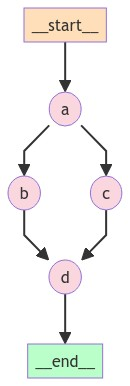

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"aggregate": []  })

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm D"]}

## Conditional Branching

If your fan-out is not deterministic, you can use [add_conditional_edges](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph.add_conditional_edges) directly.

If you have a known "sink" node that the conditional branches will route to afterwards, you can provide `then=<final-node-name>` when creating the conditional edges.

In [7]:
from typing import Sequence
from langgraph.graph import StateGraph
from typing_extensions import TypedDict
from typing import Annotated
import operator


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]
    which: str


builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.set_entry_point("a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))


def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


builder.add_conditional_edges(
    "a", route_bc_or_cd, {"b": "b", "c": "c", "d": "d"}, then="e"
)

builder.set_finish_point("e")
graph = builder.compile()

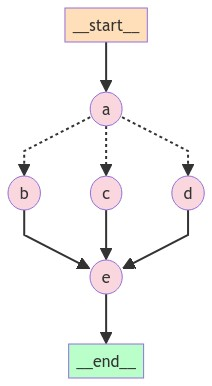

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({"aggregate": [] , "which": "bc" })

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm E to ["I'm A", "I'm B", "I'm C"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm E"], 'which': 'bc'}

In [10]:
graph.invoke({"aggregate": [] , "which": "cd" })

Adding I'm A to []
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A"]
Adding I'm E to ["I'm A", "I'm C", "I'm D"]


{'aggregate': ["I'm A", "I'm C", "I'm D", "I'm E"], 'which': 'cd'}

## Stable Sorting

When fanned out, nodes are run in parallel as a single "superstep". The updates from each superstep are all applied to the state in sequence once the superstep has completed. 

If you need consistent, predetermined ordering of updates from a parallel superstep, you should write the outputs (along with an identifying key) to a separate field in your state, then combine them in the "sink" node by adding regular `edge`'s from each of the fanout nodes to the rendezvous point.

For instance, suppose I want to order the outputs of the parallel step by "reliability".

In [15]:
from typing import Sequence
from langgraph.graph import StateGraph
from typing_extensions import TypedDict
from typing import Annotated
import operator


def reduce_fanouts(left, right):
    if left is None:
        left = []
    if not right:
        # Overwrite
        return []
    return left + right


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]
    fanout_values: Annotated[list, reduce_fanouts]
    which: str


builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.set_entry_point("a")


class ParallelReturnNodeValue:
    def __init__(
        self,
        node_secret: str,
        reliability: float,
    ):
        self._value = node_secret
        self._reliability = reliability

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']} in parallel.")
        return {
            "fanout_values": [
                {
                    "value": [self._value],
                    "reliability": self._reliability,
                }
            ]
        }


builder.add_node("b", ParallelReturnNodeValue("I'm B", reliability=0.9))

builder.add_node("c", ParallelReturnNodeValue("I'm C", reliability=0.1))
builder.add_node("d", ParallelReturnNodeValue("I'm D", reliability=0.3))


def aggregate_fanout_values(state: State) -> Any:
    # Sort by reliability
    ranked_values = sorted(
        state["fanout_values"], key=lambda x: x["reliability"], reverse=True
    )
    return {
        "aggregate": [x["value"] for x in ranked_values] + ["I'm E"],
        "fanout_values": [],
    }


builder.add_node("e", aggregate_fanout_values)


def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


builder.add_conditional_edges(
    "a", route_bc_or_cd, {"b": "b", "c": "c", "d": "d"}, then="e"
)
# builder.add_edge("b", "e")
# builder.add_edge("c", "e")
# builder.add_edge("d", "e")

builder.set_finish_point("e")
graph = builder.compile()

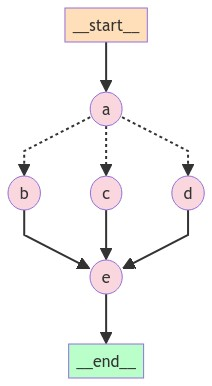

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
graph.invoke({"aggregate": [] , "which": "bc", "fanout_values": [] })

Adding I'm A to []
Adding I'm C to ["I'm A"] in parallel.
Adding I'm B to ["I'm A"] in parallel.


{'aggregate': ["I'm A", ["I'm B"], ["I'm C"], "I'm E"],
 'fanout_values': [],
 'which': 'bc'}

In [18]:
graph.invoke({"aggregate": [] , "which": "cd" })

Adding I'm A to []
Adding I'm C to ["I'm A"] in parallel.
Adding I'm D to ["I'm A"] in parallel.


{'aggregate': ["I'm A", ["I'm D"], ["I'm C"], "I'm E"],
 'fanout_values': [],
 'which': 'cd'}